In [ ]:
import uuid
from typing import Literal, TypedDict
from IPython.display import Image, display

import os
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "<your_langsmith_project_id>"
os.environ["LANGSMITH_API_KEY"] = "<your_langsmith_api_key>"
os.environ["OPENAI_API_KEY"] = "<your_openai_api_key>"

In [ ]:
from langchain.chat_models import init_chat_model
model = init_chat_model("gpt-4.1")

# initialize embeddings model (openai)
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# initialize vectordb (chromadb)
from langchain_chroma import Chroma
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data laocally, remove if not necessary
)

In [ ]:
# loading lecture notes using loader
from langchain_community.document_loaders import PyPDFLoader

folder_path = r"<your_folder_path_with_lecture_notes_in_pdf>"

docs = []

for file_path in os.listdir(folder_path):
    if (file_path.endswith(".pdf")):
        file = os.path.join(folder_path, file_path)
        content = PyPDFLoader(file).load()
        docs.extend(content)
        
# splitting documents with chunk overlap recursively
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

ids = vector_store.add_documents(documents=all_splits)

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.tools import tool

def retrieve_context(query: str):
    """Retrieve and format relevant lecture note excerpts for a given query."""
    docs = vector_store.similarity_search(query, k=10)
    
    text_blocks = "\n\n--\n\n".join(
        [f"[{i}] {doc.page_content}" for i, doc in enumerate(docs)]
    )
    
    return (text_blocks, docs)


In [ ]:
class TutorState(TypedDict):
    user_question: str
    followup_question: str
    answer: str
    prev_level: Literal["high", "mid", "low"]
    level: Literal["high", "mid", "low"]
    turns: int
    retrieved_excerpts: list
    end_session: bool
    final_output: str

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.types import Command, interrupt
from langgraph.graph import END, START, StateGraph

def classify_initial_question(state: TutorState):
    """Use LLM to classify level of misunderstanding with respect to module content"""
    user_question = state['user_question']
    retrieved_excerpts, retrieved_docs = retrieve_context(user_question)
    
    classification_prompt = f"""
    Your job is to evaluate the student's understanding by comparing their question against the retrieved lecture content.
    You are given:
    
    Student's question: {user_question}
    10 most relevant excerpts from the lecture notes: {retrieved_excerpts}
    
    Rules:
    - "high misunderstanding":
        - The question is too basic compared to the lecture content
        - The question shows incorrect assumptions or confusion
        - The question is unrelated or far below the level taught
    - "mid misunderstanding":
        - The question directly matches topics in the retrieved content
        - The question shows some understanding but not mastery
    - "low misunderstanding":
        - The question uses concepts BEYOND what is covered in the lecture
        - The question integrates deeper knowledge than the retrieved content
        - The question suggests advanced understanding
    
    Return only one word as classification: high, mid or low
    """
    
    classified_level = model.invoke(classification_prompt).content.strip().lower()
    
    return {
        "level": classified_level,
        "prev_level": classified_level,
        "retrieved_excerpts": retrieved_excerpts,
        "turns": 0,
        "answer": "",
        "followup_question": "",
        "end_session": False,
        "final_output": ""
    }

def generate_followup_question(state: TutorState) -> Command[Literal["wait_for_answer", "final_output"]]:
    """Generates followup question based on student's question with respective to lecture content"""
    current = state["level"]
    prev = state["prev_level"]
    turns = state["turns"]
    
    print(f"[DEBUG] generate_followup: current={current}, prev={prev}, turns={turns}")
    
    # new understanding level worse than before
    if (
        (prev == "low" and current == "mid") or
        (prev == "low" and current == "high") or 
        (prev == "mid" and current == "high")
    ):
        # print(f"[DEBUG] Ending: understanding got worse")
        return Command(
            update = {"end_session": True},
            goto="final_output"
        )
    
    # new understanding level same as before
    if (current == prev and turns >= 2):
        print(f"[DEBUG] Ending: same level for 3+ turns")
        return Command(
            update = {"end_session": True},
            goto="final_output"
        )
    
    # if understanding level is already good
    if (current == "low" and turns >= 3):
        print(f"[DEBUG] Ending: good understanding after 3 turns")
        return Command(
            update = {"end_session": True},
            goto="final_output"
        )
        
    # for initial round, there's no followup question, so use user_question
    if turns == 0:
        context_question = state['user_question']
    else:
        context_question = state.get('followup_question', state['user_question'])
    
    followup_question_prompt = f"""
    You are a tutoring assistant. Based on the student's misunderstanding level and their previous answer, 
    generate a SINGLE follow-up question.
    
    Current question: {context_question}
    Level of misunderstanding based on question: {current}
    Current answer: {state.get('answer', 'N.A.')} 

    - Do NOT reveal the explanation or the answer.
    - Do NOT give hints that directly contain the answer.
    - Ask only ONE question.
    - Keep the question short and clear.
    - The goal is to diagnose the misunderstanding further.
    - Your follow-up must be closely related to the student's original topic.
    - Adjust the complexity strictly based on the misunderstanding level.
    """
    
    followup_question = model.invoke(followup_question_prompt).content.strip()
    
    print(f"\nGenerated followup: {followup_question}")
    
    return Command(
        update = {
            "followup_question": followup_question,
            "prev_level": current,
            "turns": turns + 1
        },
        goto="wait_for_answer"
    )

def wait_for_answer(state: TutorState):
    """Pauses the graph and asks the student to answer the follow-up question"""
    
    question = state.get('followup_question', 'No question generated')
    print(f"[DEBUG] wait_for_answer received: {question}")
    
    answer = interrupt(
        f"Please answer this question:\n\n{question}"
    )
    
    return {"answer": answer}

def classify_followup_answer(state: TutorState):
    """Classify misunderstanding level based on student's follow-up answer"""
    
    answer = state.get("answer", "")
    original_question = state.get("user_question", "")
    followup_question = state.get('followup_question', "")
    current_level = state.get("level", "mid")
    
    print(f"\n[DEBUG] Classifying answer: '{answer[:80]}...'")
    
    retrieved_excerpts, retrieved_docs = retrieve_context(answer)
    
    classification_prompt = f"""
    You are evaluating how well a student answered a follow-up question about their understanding.
    
    Original topic: {original_question}
    Follow-up question asked: {followup_question}
    Student's answer: {answer}
    
    Relevant lecture content:
    {retrieved_excerpts}
    
    Based on this answer, classify the student's current level of misunderstanding:
    
    - "high misunderstanding": Answer shows little understanding, contains major misconceptions, or is completely off-topic
    - "mid misunderstanding": Answer shows some correct understanding but is incomplete or partially correct
    - "low misunderstanding": Answer demonstrates good or advanced understanding, shows ability to connect concepts
    
    Consider:
    1. Is the student addressing the question asked?
    2. Does the answer show understanding of the core concepts?
    3. Is the answer partially correct or mostly correct?
    4. Does it match lecture content or go beyond it?
    
    Return ONLY one word: high, mid, or low
    """
    
    new_level = model.invoke(classification_prompt).content.strip().lower()
    
    # print(f"[DEBUG] New classification is: {new_level}")
    # print(f"[DEBUG] Previous classification was: {current_level}")
    
    return Command(
        update = {"level": new_level},
        goto="generate_followup_question"
    )
    
def final_output(state: TutorState):
    # retrieved_excerpts = retrieve_context(state['question'])
    if state.get('turns', 0) >= 3:
        final_msg = state["final_output"] = f"""
        Good job! Your understanding level is quite good. I recommend you to read up
        on your notes to strengthen your understanding. You are almost there!
        """
    else:
        final_msg = state["final_output"] = f"""
        Your current level of understanding can still be improved! I recommend you to read up
        on your notes to strengthen your understanding. Do put in more effort in learning the concepts...
        """
    
    return Command(
        update={"final_output": final_msg},
        goto = END
    )

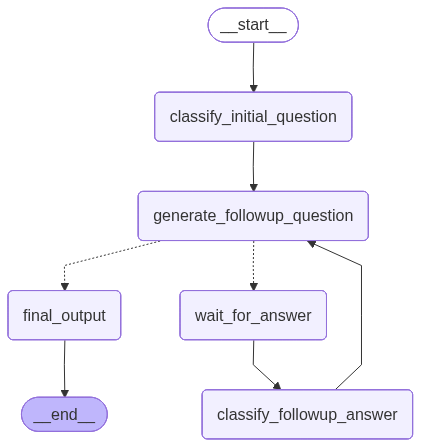

In [ ]:
builder = StateGraph(TutorState)

builder.add_node("classify_initial_question", classify_initial_question)
builder.add_node("wait_for_answer", wait_for_answer)
builder.add_node("generate_followup_question", generate_followup_question) 
builder.add_node("classify_followup_answer", classify_followup_answer)
builder.add_node("final_output", final_output)

builder.add_edge(START, "classify_initial_question")
builder.add_edge("classify_initial_question", "generate_followup_question")
builder.add_edge("wait_for_answer", "classify_followup_answer")
builder.add_edge("classify_followup_answer", "generate_followup_question")
builder.add_edge("final_output", END)

from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()
app = builder.compile(checkpointer = memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
import uuid
from langgraph.types import Command
import sys

def run_tutoring_session():
    """Run the tutoring session - optimized for Jupyter notebooks"""
    
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}}
    
    # key in your question here
    initial_input = {"user_question": "What is linear regression?"}
    
    print("Starting tutoring session...\n")
    print(f"Your question: {initial_input['user_question']}\n")
    
    state = None
    
    try:
        state = app.invoke(initial_input, config)
    except Exception as e:
        print(f"Initial invoke error: {e}")
        return
    
    turn = 0
    max_turns = 10
    
    while turn < max_turns:
        turn += 1
        
        # Check if there's an interrupt
        if state and "__interrupt__" in state and state["__interrupt__"]:
            interrupt_obj = state["__interrupt__"][0]
            interrupt_msg = interrupt_obj.value
            
            print(f"\n{'='*60}")
            print(f"Tutor is waiting for your answer...")
            print(f"{'='*60}\n")
            
            # In Jupyter, use input() with explicit prompt
            sys.stdout.flush()
            user_answer = input("Your answer: ").strip()
            
            if not user_answer:
                print("Please provide an answer.\n")
                turn -= 1
                continue
            
            print(f"\nGot your answer: '{user_answer}'")
            print(f"Processing...\n")
            
            # Resume execution
            try:
                state = app.invoke(
                    Command(resume=user_answer),
                    config
                )
            except Exception as e:
                print(f"Resume error: {e}")
                import traceback
                traceback.print_exc()
                break
        else:
            # No interrupt - session complete
            print("\n" + "="*60)
            print("🎓 Tutoring Session Complete!")
            print("="*60 + "\n")
            
            if state:
                if "final_output" in state and state["final_output"]:
                    feedback = state["final_output"].strip()
                    print(f"Final Feedback:\n{feedback}\n")
                
                turns = state.get('turns', 0)
                level = state.get('level', 'N/A')
                
                print(f"\nSession Statistics:")
                print(f"   - Questions asked: {turns}")
                print(f"   - Final misunderstanding level: {level}")
                print(f"   - Session ended: {'Yes' if state.get('end_session') else 'No'}")
            
            break
    
    if turn >= max_turns:
        print("Max turns reached. Ending session.")

# For Jupyter: Run this cell to start
print("Starting tutoring system...\n")
run_tutoring_session()

Starting tutoring system...

🎓 Starting tutoring session...

Your question: What is linear regression?

[DEBUG] generate_followup: current=mid, prev=mid, turns=0

Generated followup: What do you think is the main goal of using linear regression with data?
[DEBUG] wait_for_answer received: What do you think is the main goal of using linear regression with data?

🤖 Tutor is waiting for your answer...


✅ Got your answer: 'to find the best fit line through the data points'
Processing...

[DEBUG] wait_for_answer received: What do you think is the main goal of using linear regression with data?

[DEBUG] Classifying answer: 'to find the best fit line through the data points...'
[DEBUG] generate_followup: current=mid, prev=mid, turns=1

Generated followup: What does the "best fit line" help us do with new data points that we haven't seen before?
[DEBUG] wait_for_answer received: What does the "best fit line" help us do with new data points that we haven't seen before?

🤖 Tutor is waiting for 